<a href="https://colab.research.google.com/github/Pistolll/praktika3_TOVII/blob/main/3prak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ихтиёр М. ББМО-01-24

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [ ]:
# Загрузка датасета
url = "https://raw.githubusercontent.com/Pistolll/praktika3_TOVII/refs/heads/main/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
df = pd.read_csv(url)

# Очистка названий столбцов от пробелов и скрытых символов
df.columns = df.columns.str.strip()

# Проверим наличие метки
print("Колонки:", df.columns.tolist())
print("Уникальные значения метки:", df['Label'].unique())

# Удалим пропущенные и бесконечные значения
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df.head()


Колонки: ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE F

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
# Отделим признаки и метки
X = df.drop(columns=["Label"])
y = df["Label"]

# Масштабируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Кодируем метки
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

print("Метки классов:", list(label_encoder.classes_))


Метки классов: ['BENIGN', 'DDoS']


In [ ]:
# Определяем длину временного окна (количество последовательных шагов в одной выборке)
SEQ_LEN = 10

# Создаем пустые списки для входных последовательностей (X) и соответствующих меток (y)
X_seq, y_seq = [], []

# Проходим по данным с учетом длины окна
for i in range(len(X_scaled) - SEQ_LEN):
    # Добавляем последовательность из SEQ_LEN временных шагов (срез из нормализованных признаков)
    X_seq.append(X_scaled[i:i+SEQ_LEN])

    # В качестве метки берем следующую метку за окном — то есть предполагаем, что по последовательности
    # можно предсказать следующий шаг (важно для выявления шаблонов атак)
    y_seq.append(y_onehot[i+SEQ_LEN])

# Преобразуем списки в numpy-массивы для подачи в модель
X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Выводим размеры входов и выходов
print("X shape:", X_seq.shape)
print("y shape:", y_seq.shape)


X shape: (71068, 10, 78)
y shape: (71068, 2)


In [ ]:
# Делим данные на обучающую и валидационную выборку (80%/20%)
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Создаем модель нейросети на основе LSTM
model = Sequential([
    # LSTM-слой на 128 единиц, принимает на вход временную последовательность длины SEQ_LEN
    # и с количеством признаков, равным числу признаков в X_seq
    LSTM(128, input_shape=(SEQ_LEN, X_seq.shape[2]), return_sequences=False),

    # Dropout — регуляризация для предотвращения переобучения
    Dropout(0.3),

    # Полносвязный слой на 64 нейрона с активацией ReLU
    Dense(64, activation='relu'),

    # Еще один Dropout
    Dropout(0.3),

    # Выходной слой: число нейронов = числу классов, softmax — для многоклассовой классификации
    Dense(y_seq.shape[1], activation='softmax')
])

# Компилируем модель: используем Adam-оптимизатор и категориальную кросс-энтропию (для one-hot)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучаем модель: 10 эпох, размер пакета — 128, отслеживаем точность на валидационной выборке
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_val, y_val))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.9846 - loss: 0.0481 - val_accuracy: 0.9997 - val_loss: 0.0019
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - accuracy: 0.9993 - loss: 0.0030 - val_accuracy: 0.9997 - val_loss: 0.0015
Epoch 3/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - accuracy: 0.9997 - loss: 0.0020 - val_accuracy: 0.9998 - val_loss: 0.0014
Epoch 4/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9998 - val_loss: 0.0012
Epoch 5/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.9997 - val_loss: 0.0021
Epoch 6/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.9992 - loss: 0.0034 - val_accuracy: 0.9997 - val_loss: 0.0016
Epoch 7/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 0.9998 - val_loss: 0.0013
Epoch 8/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.9999 - loss: 0.0012 - 

445/445 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step


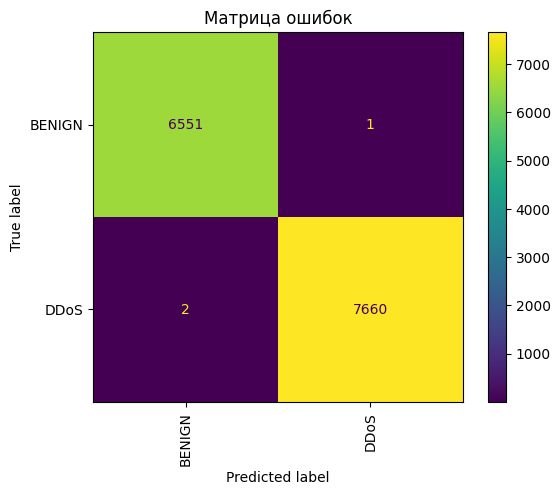

In [ ]:
# Предсказываем классы на валидационной выборке — результатом будет вероятность для каждого класса
y_pred = model.predict(X_val)

# Преобразуем вероятности в метки классов: выбираем индекс с максимальной вероятностью
y_pred_labels = np.argmax(y_pred, axis=1)

# То же самое для реальных меток: преобразуем one-hot в обычные метки
y_true_labels = np.argmax(y_val, axis=1)

# Строим матрицу ошибок (confusion matrix) — показывает, сколько раз модель угадала/ошиблась по классам
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Готовим визуализацию матрицы ошибок с подписями классов
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Отображаем матрицу ошибок с поворотом подписей по оси X
disp.plot(xticks_rotation='vertical')

# Добавляем заголовок к графику
plt.title("Матрица ошибок")

# Показываем график
plt.show()


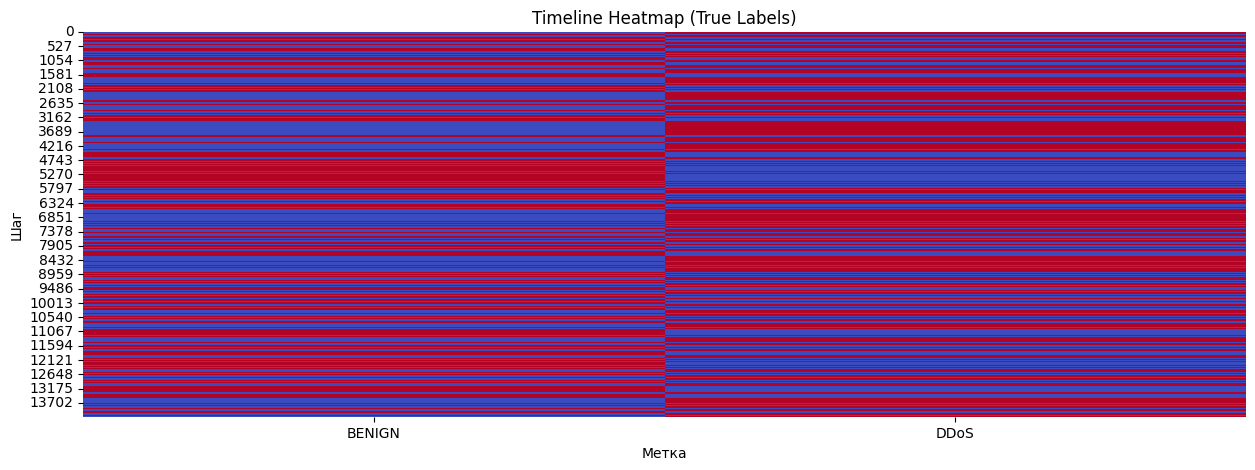

In [ ]:
# Создаем DataFrame с шагами, истинными метками и предсказанными метками
timeline = pd.DataFrame({
    "Step": range(len(y_true_labels)),  # порядковый номер шага/сессии
    "True": label_encoder.inverse_transform(y_true_labels),  # декодируем one-hot в текстовые метки
    "Predicted": label_encoder.inverse_transform(y_pred_labels)  # то же самое для предсказаний
})

# Устанавливаем размер графика
plt.figure(figsize=(15, 5))

# Строим тепловую карту по частоте появлений классов на каждом шаге (step)
# Строится кросс-таблица: строки — шаги, столбцы — метки True, значения — количество
sns.heatmap(pd.crosstab(timeline['Step'], timeline['True']), cmap="coolwarm", cbar=False)

# Заголовок графика
plt.title("Timeline Heatmap (True Labels)")

# Подписи осей
plt.xlabel("Метка")
plt.ylabel("Шаг")

# Показываем график
plt.show()
